# Zombies Spread Dynamics
Simulation of the spread of a zombie epidemic in Europe, based on the modeling of the territory with graph theory, in order to take control measures with military troops and nuclear bombs to save the largest possible population. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import os, tqdm
import datetime as dt
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
plt.style.use('default')

from libraries.dynamics import spread_zombie_dynamics as szd
from libraries.dynamics import graph_by_default

## Network reading
After executing the notebook [graph construction](https://github.com/TEAM-IMT/zombies-spread-dynamics/blob/main/Codes/Challenge_2_graphconstruction.ipynb), the file **All_nodes_graph.gexf** will be generated. For convenience, we provide this file in zip format. The file is then unzipped.

In [2]:
graph_zip = './graph/without_see_nodes_graph_ini_2.zip'
graph_path = graph_zip.replace('.zip','.gexf')
if not os.path.isfile(graph_path):
    if not os.path.isdir('graph'): os.mkdir('graph')
    !unzip $graph_zip -d "./graph"
print('[INFO] File unzip successfully.')

[INFO] File unzip successfully.


## Epidemic spread
As a first view, let's load the network and see the initial state of the two populations

In [3]:
graph_path = './graph/without_see_nodes_graph_ini_2.gexf'
G = nx.readwrite.gexf.read_gexf(graph_path)
ini_date = dt.datetime(year = 2019, month = 8, day = 18)

In [4]:
dynamic = szd(graph = G, INTIAL_DATE = ini_date)
graph_pos = {G.nodes[n]['node_id']:(eval(n)[1],-eval(n)[0]) for n in G.nodes()}

[INFO] Graph was modified ...


In [5]:
dynamic.reset()
dynamic.graph_pos = graph_pos # Use variable to set an unique perspective

<IPython.core.display.Javascript object>


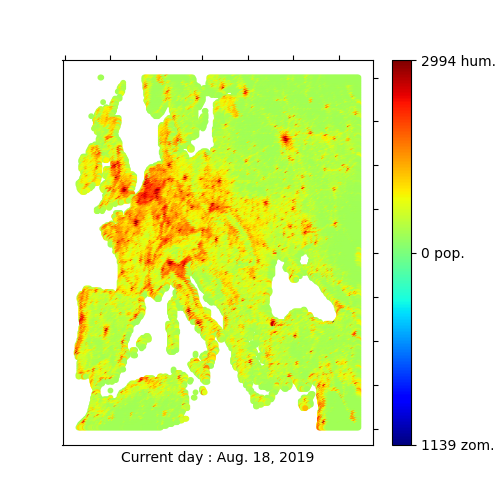

<AxesSubplot:xlabel='Current day : Aug. 18, 2019'>

In [6]:
fig, ax = plt.subplots(figsize = (5,5))
dynamic.plot_graph(ax = ax)
# Cell aux
# for neig in dynamic.graph.neighbors('U45375'):
#     print("[INFO] humanpop in",neig,":",dynamic.graph.nodes[neig]['human_pop'],
#           "\tzombiepop :",dynamic.graph.nodes[neig]['zombie_pop'],
#          "\twith elev {}".format(('U45375',neig)),":",dynamic.graph.edges[('U45375',neig)]['elev_factor'])

In [7]:
print('[INFO] First zombie population in Rize', dynamic.graph.nodes['U45375']['zombie_pop'])
print('[INFO] First human population in Brest', dynamic.graph.nodes['U28058']['human_pop'])

[INFO] First zombie population in Rize 1139
[INFO] First human population in Brest 1532


Now, let's see how it evolves over time, over the course of two months.

  0%|          | 0/185 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


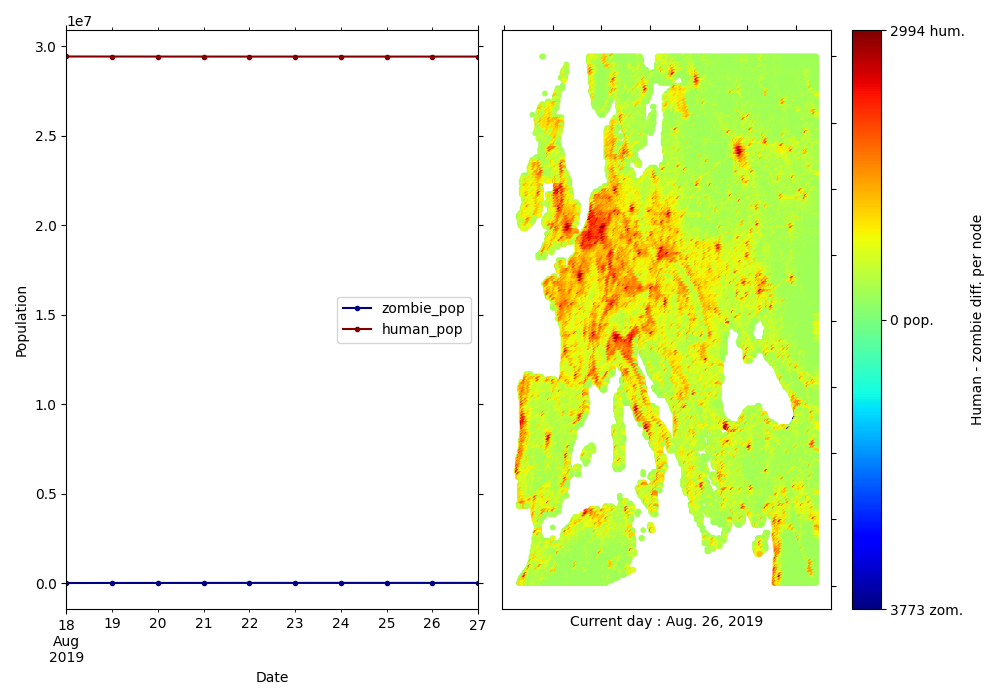

  5%|▍         | 9/185 [06:26<1:59:37, 40.78s/it]

In [ ]:
# User values
DATE_END = dt.datetime.strptime('18-02-2020', '%d-%m-%Y') # Dynamic until this date
SPECIAL_CK_DATES = pd.to_datetime(['18-10-2019', '18-12-2019', DATE_END]) # 2-4-6 months
CK_FREQ = '15D' # Checkpoints each 15days

# Define range dates and checkpoints
total_days = (DATE_END - dynamic.INTIAL_DATE).days + 1
date_cp = pd.date_range(start = dynamic.INTIAL_DATE, end = DATE_END, freq = CK_FREQ)
date_cp = date_cp.append(SPECIAL_CK_DATES)

# Create animation loop
fig, axs = plt.subplots(1,2, figsize = (10,7))
metadata = dict(title = 'Dynamic spread zombie without action', artist = 'Johansmm', 
                comment = 'Dynamic evolution without any action')
writer = FFMpegWriter(fps = 15, metadata = metadata)
trigger = True
with writer.saving(fig, "anima_zombie_wa.mp4", 300):
    for epoch in tqdm.tqdm(range(total_days)):
        dynamic.plot_all(axs = axs)
        if dynamic.current_date in date_cp:
            dynamic.save_checkpoint()
#             print(dynamic) # See basic statistics at each iteration
        if dynamic.graph.nodes['U28058']['zombie_pop'] > 0 and trigger:
            trigger = False
            print("[INFO] Zombies arrive to Brest in", dynamic.current_date.strftime("%b. %d, %Y"))
            dynamic.save_checkpoint()
        if dynamic.current_date >= DATE_END: break
        dynamic.step() # Run one step in dynamic procedure
        writer.grab_frame()

After two months, approximately one fifth of the land was conquered by the two zombies, turning 4.67% of the population into zombies, and eradicating 5.57% of the people on the European continent.

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
dynamic.plot_graph(ax = ax)
print(dynamic)

## After 2 months
Bla bla

In [ ]:
# Reset all graph, to load checkpoint
graph_path = './graph/without_see_nodes_graph_ini_2.gexf'
G = nx.readwrite.gexf.read_gexf(graph_path)
ini_date = dt.datetime(year = 2019, month = 8, day = 18)

In [ ]:
dynamic = szd(graph = G, INTIAL_DATE = ini_date)
dynamic.load_checkpoint('checkpoints/szd_18-10-2019.dyn')

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (12,6))
dynamic.plot_all(axs = axs)
axs[0].set_title('(a)'); axs[1].set_title('(b)')
fig.tight_layout()
fig.savefig('images/result_2months.png', dpi=300, facecolor='w', edgecolor='k', pad_inches=0.0,)